# Auxiliary Mesh Data Structure

We discuss ways to extract the combinatorial structure of a triangulation by using `elem` array only. Auxiliary data structure includes: 
- 2D: `edge, elem2edge, edge2elem, neighbor, bdEdge`
- 3D: `face, elem2face, face2elem, neighbor, bdFace`

They are wrapped into a mesh structure `T` and generated by
```
    T = auxstructure(elem);  % 2-D
    T = auxstructure3(elem); % 3-D
```

The auxiliary data structure can be constructed by *sparse matrixlization* efficiently; see [Auxiliary Mesh Data Structure](auxstructuredoc.pdf) for detailed explanation. In the following, we present two examples.

## edge
We first complete the 2-D simplicial complex represented by `elem` by constructing 1-dimensional simplices, i.e., edges of the triangulation. We use `edge(1:NE,1:2)` to store indices of the starting and ending points of edges. The column is sorted in a way such that for the k-th edge, `edge(k,1)<edge(k,2)`. The following code will generate an `edge` matrix. 

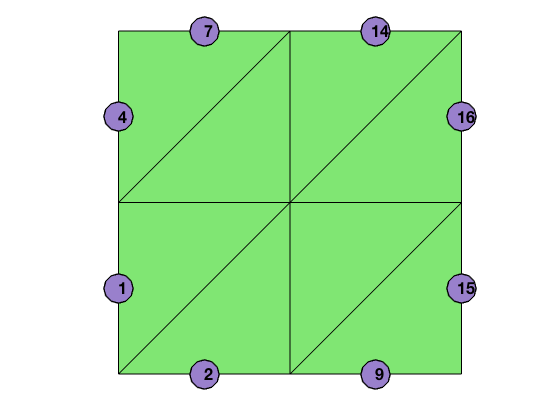

In [3]:
[node,elem] = squaremesh([0 1 0 1],0.5);
totalEdge = sort([elem(:,[2,3]); elem(:,[3,1]); elem(:,[1,2])],2);
[i,j,s] = find(sparse(totalEdge(:,2),totalEdge(:,1),1));
edge = [j,i]; 
bdEdge = [j(s==1),i(s==1)];
showmesh(node,elem);
findedge(node,edge,s==1);

The first line collects all edges from the set of triangles and sorts the column such that `totalEdge(k,1)<totalEdge(k,2)`. The interior edges are repeated twice in `totalEdge`. We use the summation property of `sparse` command to merge the duplicated indices. The nonzero vector `s` takes value 1 (for boundary edges) or 2 (for interior edges). We then use `find` to return the nonzero indices which forms the `edge` set. We can also find the boundary edges using the subset of indices pair corresponding to the nonzero value 1. Note that we switch the order of `(i,j)` in line 3 to sort the edge set row-wise since the output of `find(sparse)` is sorted column-wise. 

To construct `edge` matrix only, the above 3 line code can be further simplified to one line:
`edge = unique(sort([elem(:,[2,3]); elem(:,[3,1]); elem(:,[1,2])],2),'rows');`
The `unique` function provides more functionality which we shall explore more later. However, numerical tests show that the running time of `unique` is around 3 times of the combination `find(sparse)`. 

## Node Star

The `elem` matrix, by the definition, is a link from triangles to vertices, i.e., `elem` is `elem2node`. The link from vertices to triangles, namely given a vertex, to find all triangles containing this vertex, is stored in the sparse matrix:

     1     0     0     1     1     0     0     0     0
     0     1     0     0     1     1     0     0     0
     0     0     0     1     0     0     1     1     0
     0     0     0     0     1     0     0     1     1
     1     1     0     0     1     0     0     0     0
     0     1     1     0     0     1     0     0     0
     0     0     0     1     1     0     0     1     0
     0     0     0     0     1     1     0     0     1



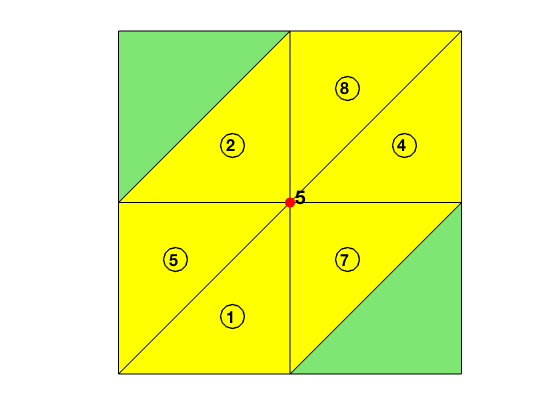

In [8]:
NT = size(elem,1); N = size(node,1);
t2v = sparse([1:NT,1:NT,1:NT], elem, 1, NT, N);
display(full(t2v));
nodeStar = find(t2v(:,5));
showmesh(node,elem);
findelem(node,elem,nodeStar);
findnode(node,5);

The NT x N matrix `t2v` is the incidence matrix between triangles and vertices. `t2v(t,i)=1` means the i-th node is a vertex of triangle t. If we look at `t2v` column-wise, the nonzero in the i-th column of `t2v(:,i)` will give all triangles containing the $i$-th node. Since sparse matrix is stored column-wise, the star of the $i$-th node can be efficiently found by `nodeStar = find(t2v(:,i))`.

## elem2edge

We label three edges of a triangle such that the i-th edge is opposite to the i-th vertex. We define the matrix `elem2edge` as the map of local index of edges in each triangle to its global index. The following 3 line code will construct `elem2edge` using more output from `unique` function.

In [2]:
[node,elem] = squaremesh([0 1 0 1],0.5);
totalEdge = sort([elem(:,[2,3]); elem(:,[3,1]); elem(:,[1,2])],2);
[edge, i2, j] = unique(totalEdge,'rows','legacy');
NT = size(elem,1);
elem2edge = reshape(j,NT,3);

Line 1 collects all edges element-wise. The size of `totalEdge` is thus 3NT x 2. By the construction, there is a natural index mapping from `totalEdge` to `elem`. In line 2, we apply `unique` function to obtain the edge matrix. The output index vectors `i2` and `j` contain the index mapping between `edge` and `totalEdge`. Here `i2` is a NE x 1 vector to index the last (2-nd in our case) occurrence of each unique value in `totalEdge` such that `edge = totalEdge(i2,:)`, while `j` is a 3NT x 1 vector such that `totalEdge = edge(j,:)`. (Try `help unique` in MATLAB to learn more examples. `legacy` is used since the version change of MATLAB.) Then using the natural index mapping from `totalEdge` to `elem`, we reshape the 3NT x 1 vector `j` to a NT x 3 matrix which is `elem2edge`.


elem2edge =

     3     2     8
     6     5    11
    10     9    15
    13    12    16
     3     5     1
     6     7     4
    10    12     8
    13    14    11



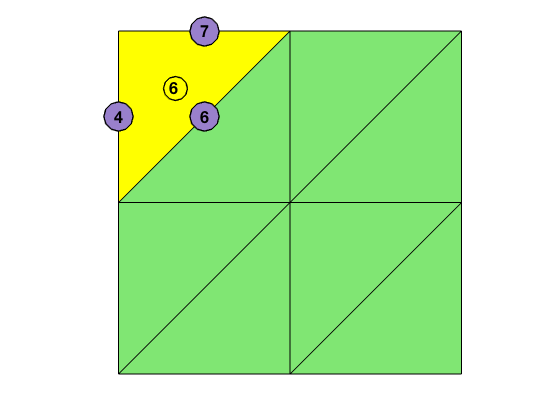

In [3]:
showmesh(node,elem);
findelem(node,elem,6);
findedge(node,edge,elem2edge(6,:));
display(elem2edge);

## edge2elem

We then define a NE x 4 matrix `edge2elem` such that `edge2elem(k,1)` and `edge2elem(k,2)` are two triangles sharing the k-th edge for an interior edge. If the k-th edge is on the boundary, then we set `edge2elem(k,1) = edge2elem(k,2)`. Furthermore, we shall record the local indices in `edge2elem(k,3:4)` such that `elem2edge(edge2elem(k,1),edge2elem(k,3))=k`. Similarly `edge2elem(k,4)` is the local index of k-th edge in `edge2elem(k,2)`. 

To construct `edge2elem` matrix, we need to find out the index map from `edge` to `elem`. The following code is a continuation of the code constructing `elem2edge`.

In [7]:
i1(j(3*NT:-1:1)) = 3*NT:-1:1; i1=i1';
k1 = ceil(i1/NT); t1 = i1 - NT*(k1-1);
k2 = ceil(i2/NT); t2 = i2 - NT*(k2-1);
edge2elem = [t1,t2,k1,k2];

The code in line 1 uses `j` to find the first occurrence of each unique edge in the `totalEdge`. In MATLAB, when assign values using an index vector with duplication, the value at the repeated index will be the last one assigned to this location. Obvious `j` contains duplication of edge indices. For example, `j(1)=j(2)=4` which means `totalEdge(1,:)=totalEdge(2,:)=edge(4,:)`. We reverse the order of `j` such that `i1(4)=1` which is the first occurrence.

Using the natural index mapping from `totalEdge` to `elem`, for an index `i` between `1:N`, the formula `k=ceil(i/NT)` computes the local index of i-th edge, and `t=i-NT*(k-1)` is the global index of the triangle which `totalEdge(i,:)` belongs to. The `edge2elem` is just composed by `t1,t2,k1` and `k2`.


edge2elem =

     5     5     3     3
     1     1     2     2
     1     5     1     1
     6     6     3     3
     2     5     2     2
     2     6     1     1
     6     6     2     2
     1     7     3     3
     3     3     2     2
     3     7     1     1
     2     8     3     3
     4     7     2     2
     4     8     1     1
     8     8     2     2
     3     3     3     3
     4     4     3     3



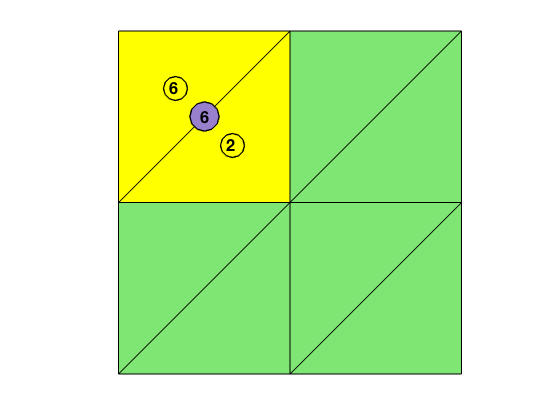

In [9]:
showmesh(node,elem);
findelem(node,elem,edge2elem(6,1:2));
findedge(node,edge,6);
display(edge2elem);